# [without library] <font color="orange">Binary Classification using Logistic Regression
</font>

### Based on - [2010] Generative and Discriminative Classifiers : Naive Bayes and Logistic Regression - <font color=magenta>Tom Mitchell</font>

## Introduction

This notebook implements <font color=blue>Binomial Logistic Regression</font>. It performs <font color=blue>binary classification</font> on a generated dataset consisting of two gaussian distributed clusters of points in a 2-dimensional space. The prediction accuracy for a learning dataset of 100 points is <font color=blue>98-99%</font>.

Resources:
- [Generative and Discriminative Classifiers : Naive Bayes and Logistic Regression]https://www.cs.cmu.edu/~tom/mlbook/NBayesLogReg.pdf)

Towards the end, I have included a <font color=blue>sidebar</font> on the <font color=magenta>Binomial Logistic Regression</font>. 

## Taxonomy

## Imports

In [1]:
from math import log # to calculate posterior probability
import numpy as np #arrays for data points
from numpy.random import rand, normal, randint #gaussian distributed data points
from numpy import dot #vector dot product for the linear kernel
from numpy import mean, std #mean and standard deviation for gaussian probabilities
from scipy.stats import norm #gaussian probabilities
import pandas as pd #input
import seaborn as sns #plotting
%matplotlib inline

## Constants

In [2]:
learning_rate = 0.01

## X_m, Y

### Data Configuration

In [3]:
M = 100 #number of data points
cols = ['X0', 'X1', 'X2', 'Y'] #column names of the dataframe
n_features = len(cols)-1 #number of dimensions
K = 2 #number of classes
loc_scale = [(5, 1), (10, 1)] #mean and std of data points belonging to each class

### Generate Data
Gaussian clusters in 2D numpy arrays

In [4]:
def generate_X_m_and_Y(M, K, n_features, loc_scale):
    #X_m, Y
    # we use this extra count (+1) to accomodate for X0 = 1 (the attribute for bias)
    X_m = np.ones((K, (int)(M/2), n_features), dtype=float) #initialize data points
    Y = np.empty((K, (int)(M/2)), dtype=int) #initialize the class labels

    for k in range(K): #for each class, generate data points #create data points for each class
        #create data points for class k using gaussian (normal) distribution
        X_m[k][:, 1:] = normal(loc=loc_scale[k][0], scale=loc_scale[k][1], size=((int)(M/2), n_features-1))
        #append features/columns after the bias (first) column
        #X_m[:, 1:] = X
        #create labels (0, 1) for class k (0, 1).
        Y[k] = np.full(((int)(M/2)), k, dtype=int)
    X_m = X_m.reshape(M, n_features) #collapse the class axis
    Y = Y.reshape(M) #collapse the class axis
    X_m.shape, Y.shape #print shapes
    
    return X_m, Y

X_m, Y = generate_X_m_and_Y(M, K, n_features, loc_scale)
X_m.shape, Y.shape

((100, 3), (100,))

### X_m, Y in DataFrame

In [5]:
def create_df_from_array(X_m, Y, n_features, cols):
    #create series from each column of X_m, and a series from Y
    l_series = [] #list of series, one for each column
    for feat in range(n_features): #create series from each column of X_m
        l_series.append(pd.Series(X_m[:, feat])) #create series from a column of X_m
    l_series.append(pd.Series(Y[:])) #create series from Y

    frame = {col : series for col, series in zip(cols, l_series)} #map of column names to series
    df = pd.DataFrame(frame) #create dataframe from map

    return df

df = create_df_from_array(X_m, Y, n_features, cols)
df.sample(n = 10)

,X0,X1,X2,Y
51,1.0,8.353118,10.571003,1
36,1.0,3.603399,4.816312,0
53,1.0,10.205741,9.484240,1
5,1.0,6.361893,6.332490,0
64,1.0,8.147273,10.845056,1
29,1.0,2.857948,4.605058,0
60,1.0,10.714859,10.702065,1
7,1.0,4.363048,3.603280,0
67,1.0,11.910404,10.167950,1
61,1.0,7.680741,10.046152,1


<AxesSubplot:xlabel='X1', ylabel='X2'>

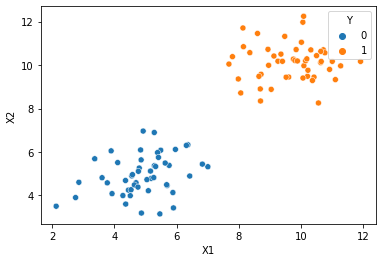

In [6]:
#scatter plot of data points
#class column Y is passed in as hue
sns.scatterplot(x=cols[1], y=cols[2], hue=cols[3], data=df)

## Model

### linear combination of weights and coefficients

In [7]:
def lin_com(w, x):
    return np.dot(w, x)

### P(Y=0|X,W)

In [8]:
def prob_y0_x(w, x):
    lc = lin_com(w, x)
    return 1/(1 + np.exp(lc))

### P(Y=1|X,W)

In [9]:
def prob_y1_x(w, x):
    lc = lin_com(w, x)
    return np.exp(lc)/(1 + np.exp(lc))

### ln(W) = sigma_l (Y * ln(P(Y=1|X,W)) + (1-Y) * ln(P(Y=0|X,W))) - <font color='magenta'>conditional data log-likelihood</font>

In [10]:
#conditional data log-likelihood ln(P(Y|X,W))
def cond_data_log_likelihood(X_m, Y, w):
    likelihood = 0.0
    for i in range(len(X_m)):
        likelihood += (Y[i]*log(prob_y1_x(w, X_m[i])) + (1 - Y[i])*log(prob_y0_x(w, X_m[i])) )
    return (likelihood)

### d(ln(W))/dW_i - <font color='magenta'>gradient along attribute 'i'</font>

In [11]:
#gradient along the attribute 'j'
def gradient(X_m, Y, W, j):
    grad = 0.0
    #iterate over all data-points
    for i in range(len(X_m)):
        grad += X_m[i][j]*(Y[i] - prob_y1_x(W, X_m[i]))
    return grad

### <font color='magenta'>gradients along attributes</font>

In [12]:
#gradient along each attribute
def gradients(X_m, Y, W):
    #gradient along each attribute
    grads = np.zeros(len(W), dtype=float)
    for j in range(len(W)):
        grads[j] = gradient(X_m, Y, W, j)
        
    return grads

### apply gradients on coefficients

In [13]:
def apply_gradient(W, grads, learning_rate):
    return (W + (learning_rate * grads))

### Training Algorithm

In [14]:
def train(X_m, Y, W, learning_rate):
    #learn
    prev_max = cond_data_log_likelihood(X_m, Y, W)
    grads = gradients(X_m, Y, W)
    W = apply_gradient(W, grads, learning_rate)
    new_max = cond_data_log_likelihood(X_m, Y, W)
    while(abs(prev_max - new_max) > 0.01):
        prev_max = new_max
        grads = gradients(X_m, Y, W)
        W = apply_gradient(W, grads, learning_rate)
        new_max = cond_data_log_likelihood(X_m, Y, W)

    return W

### Learn

In [15]:
#weights
W = np.zeros((n_features), dtype=float)
W = train(X_m, Y, W, learning_rate)

#### <font color=magenta>weights (coefficients)</font>

In [16]:
print('The learnt weights (coefficients) are:', W)

The learnt weights (coefficients) are: [-24.68237564  -0.39234845   3.66081697]


## Prediction

### Generate Data
Gaussian clusters in 2D numpy arrays

In [17]:
X_m, Y = generate_X_m_and_Y(M, K, n_features, loc_scale) #generate test data points

### Predict

In [18]:
Y_pred = [prob_y1_x(W, X) for X in X_m]
Y_pred_class = [0 if y < 0.5 else 1 for y in Y_pred] #decision based on predicted margin

### Predicted X_m, Y in DataFrame

In [19]:
df = create_df_from_array(X_m, Y, n_features, cols) #create test dataframe
df['Y_pred_margin'] = Y_pred #append the prediction margin column
df['Y_pred_class'] = Y_pred_class #append the class
df.sample(n = 10)

,X0,X1,X2,Y,Y_pred_margin,Y_pred_class
80,1.0,8.535469,11.275575,1,9.999982e-01,1
33,1.0,6.469280,5.947414,0,4.285623e-03,0
20,1.0,4.462977,4.555431,0,5.789524e-05,0
19,1.0,6.595669,4.277625,0,9.069587e-06,0
23,1.0,5.861374,3.942381,0,3.545812e-06,0
7,1.0,3.843687,5.352134,0,1.362246e-03,0
93,1.0,9.002853,12.715624,1,1.000000e+00,1
12,1.0,4.027771,3.934127,0,7.063614e-06,0
98,1.0,8.830713,9.223774,1,9.963865e-01,1
8,1.0,6.870983,3.470701,0,4.243973e-07,0


<AxesSubplot:xlabel='X1', ylabel='X2'>

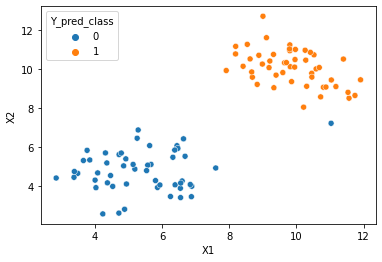

In [22]:
#scatter plot of data points
#class column Y is passed in as hue
sns.scatterplot(x=cols[1], y=cols[2], hue='Y_pred_class', data=df)

### <font color=magenta>Prediction Accuracy</font>

In [23]:
Y_pred_corr = (Y==Y_pred_class)
num_corr = len(Y_pred_corr[Y_pred_corr == True])
print('Accuracy:', (num_corr/M)*100, '%')

Accuracy: 99.0 %
